In [33]:
import tensorflow as tf

In [34]:
from keras.preprocessing.image import ImageDataGenerator

In [35]:
import os, shutil

In [36]:
print(os.getcwd())

/Users/alessandrobiagi/Desktop/Kaggle_Datasets/Kaggle_Bradipi/FoodRecognition/scripts


In [37]:
def creating_dataset_directories(type_dir, category):
    new_cat_dir = os.path.join(type_dir, category)
    if not new_cat_dir:
        os.mkdir(new_cat_dir)


In [38]:
# Directory where you'll store your dataset
base_dir = '../src/food-101/'

# Directories for the training, validation, and test splits
train_dir = os.path.join(base_dir, 'train')
if not train_dir:
    os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not validation_dir:
    os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not test_dir:
    os.mkdir(test_dir)

In [39]:
categories = ['sashimi', 'spaghetti_bol']
type_dirs = [train_dir, validation_dir, test_dir]

for category in categories:
    for type_dir in type_dirs:
        creating_dataset_directories(type_dir=type_dir,
                                     category=category)

In [40]:
sashimi_dir = base_dir + 'images/sashimi'
spaghetti_bol_dir = base_dir + 'images/spaghetti_bolognese'

sashimi_names = os.listdir(sashimi_dir)
sashimi_full_names = [os.path.join(sashimi_dir, x) for x in sashimi_names]

spaghetti_bol_names = os.listdir(spaghetti_bol_dir)
spaghetti_bol_full_names = [os.path.join(spaghetti_bol_dir, x) for x in spaghetti_bol_names]


In [41]:
print(len(sashimi_names))
print(len(spaghetti_bol_names))

1000
1000


In [42]:
sashimi_train_names = sashimi_full_names[0:700]
sashimi_val_names = sashimi_full_names[700:850]
sashimi_test_names = sashimi_full_names[850:100]

In [43]:
spaghetti_bol_train_names = spaghetti_bol_full_names[0:700]
spaghetti_bol_val_names = spaghetti_bol_full_names[700:850]
spaghetti_bol_test_names = spaghetti_bol_full_names[850:1000]

In [44]:
def creating_datasets(dataset_names, dst_dir, type_dir, category):
    for x in dataset_names:
        img_name = x.split("/")[-1]
        dst_dir_type = os.path.join(dst_dir, type_dir)
        dst_dir_full = os.path.join(dst_dir_type, category)
        dst = os.path.join(dst_dir_full, img_name)
        shutil.copy(x, dst)

In [45]:
base_dst_dir_dataset = '../src/food-101'
sashimi_names_list = [sashimi_train_names, sashimi_val_names, sashimi_test_names]
spaghetti_bol_list = [spaghetti_bol_train_names, spaghetti_bol_val_names, spaghetti_bol_test_names]
type_dataset = ['train', 'validation', 'test']
categories_dataset = ['sashimi', 'spaghetti_bol']

In [48]:
for category in categories_dataset:
    if category == 'sashimi':
        dataset_names_list = sashimi_names_list
    elif category == 'spaghetti_bol':
        dataset_names_list = spaghetti_bol_list

In [49]:
creating_datasets(dataset_names=sashimi_train_names,
                 dst_dir='../src/food-101/',
                 type_dir='train',
                 category='sashimi')

In [50]:
creating_datasets(dataset_names=sashimi_val_names,
                 dst_dir='../src/food-101/',
                 type_dir='validation',
                 category='sashimi')

In [51]:
creating_datasets(dataset_names=sashimi_test_names,
                 dst_dir='../src/food-101/',
                 type_dir='test',
                 category='sashimi')

In [52]:
creating_datasets(dataset_names=spaghetti_bol_train_names,
                 dst_dir='../src/food-101/',
                 type_dir='train',
                 category='spaghetti_bol')

In [53]:
creating_datasets(dataset_names=spaghetti_bol_val_names,
                 dst_dir='../src/food-101/',
                 type_dir='validation',
                 category='spaghetti_bol')

In [54]:
creating_datasets(dataset_names=spaghetti_bol_test_names,
                 dst_dir='../src/food-101/',
                 type_dir='test',
                 category='spaghetti_bol')

In [55]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [56]:
train_dir

'../src/food-101/train'

In [57]:
train_generator = train_datagen.flow_from_directory(
                                train_dir,
                                target_size=(150, 150), # resize all images to 150 x 150
                                batch_size=20,
                                class_mode='binary')

Found 1400 images belonging to 2 classes.


In [58]:
validation_generator = test_datagen.flow_from_directory(
                                validation_dir,
                                target_size=(150, 150),
                                batch_size=20,
                                class_mode='binary')

Found 300 images belonging to 2 classes.


In [59]:
from keras import layers
from keras import models

# Features extractor
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [60]:
# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [61]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)      

In [62]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

In [63]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch=70,
                epochs=30,
                validation_data=validation_generator,
                validation_steps=15)

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
70/70 [==============================] - 31s 433ms/step - loss: 0.6319 - acc: 0.6344 - val_loss: 0.4521 - val_acc: 0.7900
Epoch 2/30
70/70 [==============================] - 31s 438ms/step - loss: 0.4275 - acc: 0.8052 - val_loss: 0.3705 - val_acc: 0.8533
Epoch 3/30
70/70 [==============================] - 31s 438ms/step - loss: 0.3141 - acc: 0.8736 - val_loss: 0.2717 - val_acc: 0.8900
Epoch 4/30
70/70 [==============================] - 31s 438ms/step - loss: 0.2681 - acc: 0.8880 - val_loss: 0.2800 - val_acc: 0.8900
Epoch 5/30
70/70 [==============================] - 31s 435ms/step - loss: 0.2327 - acc: 0.9037 - val_loss: 0.2197 - val_acc: 0.9133
Epoch 6/30
70/70 [==============================] - 32s 464ms/step - loss: 0.2230 - acc: 0.9058 - val_loss: 0.2551 - val_acc: 0.8967
Epoch 7/30
70/70 [==============================] - 33s 469ms/step - loss: 0.2326 - acc: 0.9178 - val_loss: 0.2145 - val_acc: 0.9167
Epoch 8/30
70/70 [==============================] - 32s 451ms/step - 

In [64]:
model.save('../models/conv_net_20201228_1.h5')

In [67]:
history.history

{'loss': [0.5732683539390564,
  0.401833176612854,
  0.31424033641815186,
  0.2526271641254425,
  0.21427729725837708,
  0.21375614404678345,
  0.2059619426727295,
  0.1875188946723938,
  0.16028593480587006,
  0.1614397168159485,
  0.14478081464767456,
  0.13128234446048737,
  0.13172204792499542,
  0.12265979498624802,
  0.10888516902923584,
  0.1039871871471405,
  0.09312955290079117,
  0.08908472955226898,
  0.07202228903770447,
  0.07798997312784195,
  0.0498427152633667,
  0.04982469975948334,
  0.05827052891254425,
  0.04058379679918289,
  0.03943557292222977,
  0.046411819756031036,
  0.03021511621773243,
  0.02880350686609745,
  0.04199346527457237,
  0.01756606437265873],
 'acc': [0.6985714435577393,
  0.8199999928474426,
  0.8692857027053833,
  0.8999999761581421,
  0.9157142639160156,
  0.9221428632736206,
  0.925000011920929,
  0.9257143139839172,
  0.9399999976158142,
  0.9364285469055176,
  0.941428542137146,
  0.949999988079071,
  0.9571428298950195,
  0.954999983310699

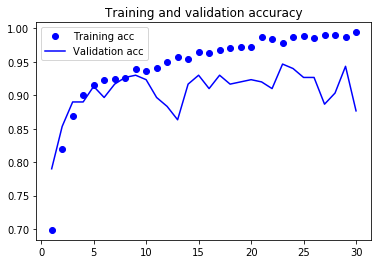

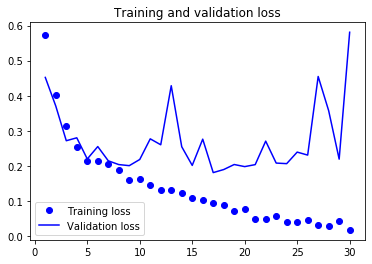

In [66]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()